<a href="https://colab.research.google.com/github/simrathanspal/deep_models_from_scratch/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UI based training - https://remykarem.github.io/word2vec-demo/

In [1]:
corpus = [
    "The king is a strong and wise ruler.",
    "The queen is a wise and powerful monarch.",
    "A man must be strong to be a king.",
    "A woman can be a powerful monarch.",
    "The ruler of the kingdom is either a king or a queen.",
    "He is the king and she is the queen.",
]

# Two word2vec architectures

Shallow 2 layer network
2 layers because two sets of learnable parameters

1.   input -> hidden
2.   hidden -> output



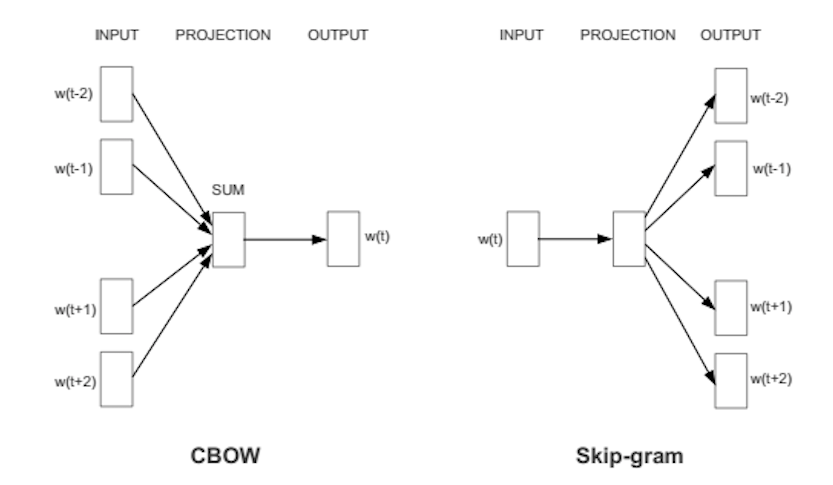

## Skip Gram - predict the surrounding context

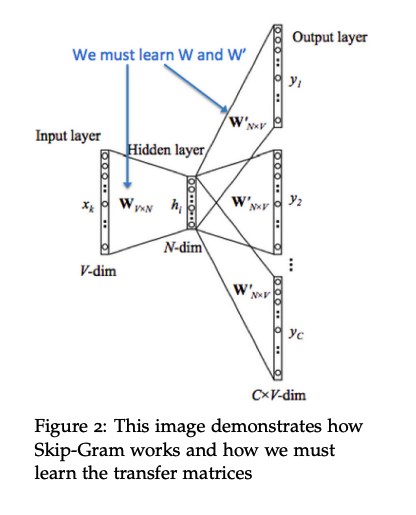

In the skip gram model we are training bunch of target and context token pairs

Consider the sentence `"The quick brown fox jumped over the dog"`

If target word is `jumped` then we create pairs like

`(jumped, brown), (jumped, fox), (jumped, over), (jumped, the)`

We dont care about the position here, all we care about is teaching the model the associations and updating the target embedding.

In my view this is a confusing training setup as one word has to predict always different words. But as a training task I think it is a good setup because it avoids overfitting and forces the model to generalise well.

Especially important as the complexity of the task is not much - just predicting the next word.

In [2]:
import numpy as np

vocab = sorted(np.unique(np.concatenate([c.split() for c in corpus])))
word_to_index = {word: index for index, word in enumerate(vocab)}
index_to_word = {index: word for index, word in enumerate(vocab)}


def one_hot_vec(index, size):
  vec = np.zeros(size)
  vec[index] = 1
  return vec

In [3]:
def generate_skip_gram_data(window_size=1):
  training_data = []
  for line in corpus:
    tokens = line.split()
    for i, target in enumerate(tokens):
      index = word_to_index[target]
      context = []
      for j in range(max(0,i-window_size) , min(len(tokens), i+window_size+1)):
        if i == j:
          continue
        training_data.append([index, word_to_index[tokens[j]]])
  return training_data



In [4]:
# Model parameters
hidden_dim = 5
learning_rate = 0.01
epochs = 500 # Number of times the model sees whole data

# Weight initialisation
# Random value from -1 (inclusive) to 1 (exclusive)
W1 = np.random.uniform(-1, 1, (len(vocab), hidden_dim))
W2 = np.random.uniform(-1, 1, (hidden_dim, len(vocab)))

In [5]:
training_data_skip = generate_skip_gram_data()
print(training_data_skip[0])


# ---- Training loop ----
for epoch in range(epochs):
  total_loss = 0
  for target_idx, context in training_data_skip:
    # 1. Get one hot vector for target word
    x = one_hot_vec(target_idx, len(vocab))

    # 2. Get the embedding
    h = W1.T@x

    # 3. Score for all context words
    u = W2.T@h

    # 4. Calculate probabilities
    y_pred = np.exp(u)/np.sum(np.exp(u))


    # --- Calculate loss --- #
    loss = -np.log(y_pred[context])
    total_loss += loss

    # ---- Backward pass ---- #

    # Explanation
    #
    # Consider we have bunch of neuron weight going to output neuron.
    # We want to now distribute the Loss at output neuron to all the previous neurons.
    # For this we need to understand what is the contribution of every previous neuron to the loss.
    #
    # dLoss/dW = (dLoss/du).(du/dW)
    #
    # Change in Loss for a small change in weights =
    # (Change in Loss for a small change in Output) x (Change in Output for a small change in weights)
    # du/dwi = d(w0X0 + w1x1 + ...wiXi+... )/dwi
    # When taking a derivative for wi, all the other weights are treated as constant and derivative will be 0
    # Hence du/dwi = Xi (same as activation at last layer and input at the first layer) or h in our case
    #
    # Now we need to compute (dL/du)
    # Loss = cross entropy of softmax
    # Output = softmax of logits
    # First we take softmax (y_pred) = e^(logit_i)/ sum of all logit exponentials
    # Next we take cross entropy = - Sum of all classes [ y_true.log(y_pred) ]
    # derivative of cross entropy = y_pred - y_actual
    # Note the derivative of other loss function need not be y_pred - y_loss hence we can't simiplify like this

    # 1. calculate error
    # error is difference between predicted and expected probabilities
    e = y_pred.copy()
    # y_pred - y_act
    # 0.85 - 1 => -0.15 => Gives the direction that prob is low
    # 0.85 - 0 => 0.85 => Gives the direction that prob is high
    # Hence we need to subtract -1 only for target class
    e[context] -= 1

    # 2. Calculate the gradient for W2
    grad_W2 = np.outer(h, e)

    # 3. Calculate the gradient for W1
    # Distributing the error back is slightly unintuitive but we can understand this with an analogy
    # Imagine that hidden layer is a water source and from this water source the water is flowing to
    # final destination. Every neuron connection can be thought of as a channel.
    # The width of the channel defines how much water flows through it and this is what our weights are
    # controlling - how much information flows.
    # Now when we want to back propogate the error we need to send it through the same channel
    # Hence the error reaching the previous layer is distributed by the weight
    grad_W1 = np.outer(x, W2@e)

    # --- Update weights --- #
    W1 -= learning_rate * grad_W1
    W2 -= learning_rate * grad_W2

  print(f"Epoch: {epoch+1}, Loss: {total_loss}")
print("\n--- Skip-gram Final Embeddings (W1) ---")
print(W1)


[2, 9]
Epoch: 1, Loss: 346.5241847160498
Epoch: 2, Loss: 341.1167393756928
Epoch: 3, Loss: 336.224888268754
Epoch: 4, Loss: 331.76633225553394
Epoch: 5, Loss: 327.67447334076047
Epoch: 6, Loss: 323.89482856023926
Epoch: 7, Loss: 320.3824007347007
Epoch: 8, Loss: 317.0997123160953
Epoch: 9, Loss: 314.01531090981933
Epoch: 10, Loss: 311.10261754370237
Epoch: 11, Loss: 308.3390285208134
Epoch: 12, Loss: 305.70520785336066
Epoch: 13, Loss: 303.184524947156
Epoch: 14, Loss: 300.76260440097
Epoch: 15, Loss: 298.4269633454857
Epoch: 16, Loss: 296.16671784001556
Epoch: 17, Loss: 293.9723442341248
Epoch: 18, Loss: 291.8354845966257
Epoch: 19, Loss: 289.748787665995
Epoch: 20, Loss: 287.7057785274685
Epoch: 21, Loss: 285.7007515440592
Epoch: 22, Loss: 283.7286820823848
Epoch: 23, Loss: 281.7851533650124
Epoch: 24, Loss: 279.86629540979857
Epoch: 25, Loss: 277.96873352701493
Epoch: 26, Loss: 276.08954426901107
Epoch: 27, Loss: 274.22621708920866
Epoch: 28, Loss: 272.3766202865352
Epoch: 29, Loss:

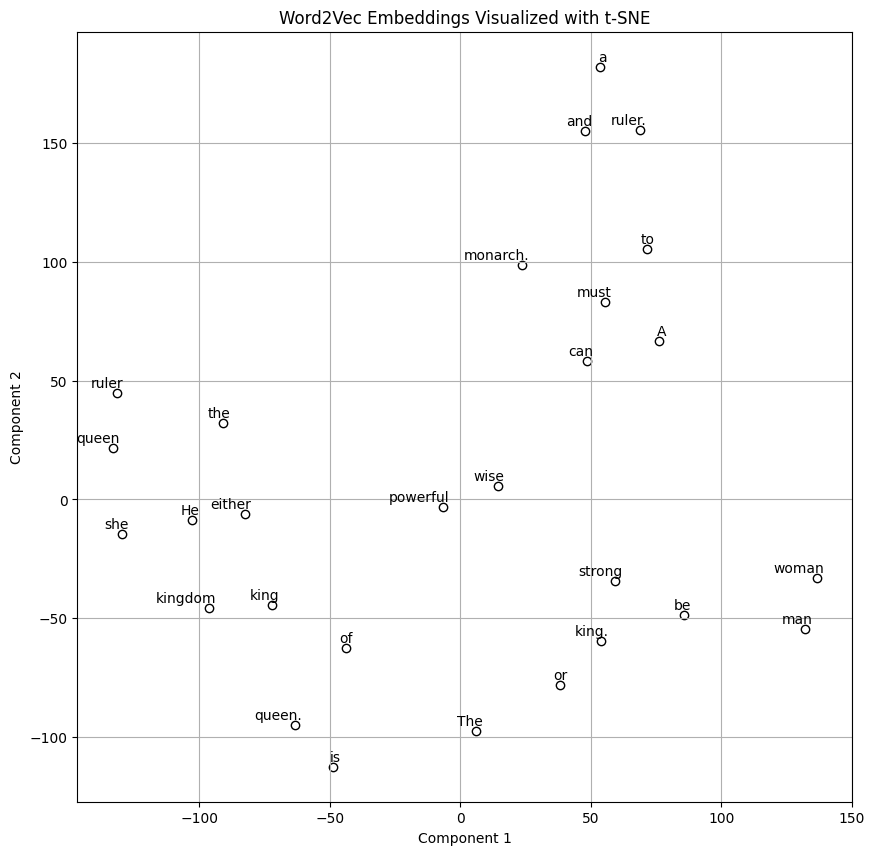

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(W1)
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], edgecolors='k', c='w')

for i, word in enumerate(vocab):
    plt.annotate(word,
                 xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
                 xytext=(5, 2), # Small offset
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.title('Word2Vec Embeddings Visualized with t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

# CBOW - Given the surrounding context predict the target

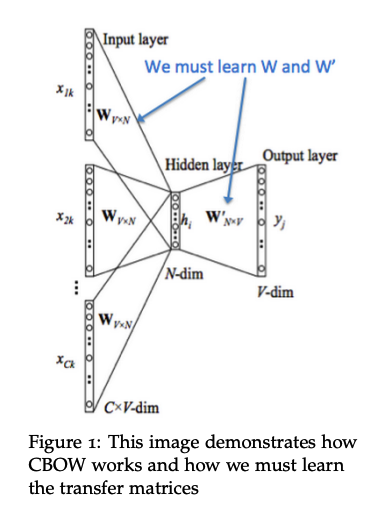

In CBOW we do the opposite of skip gram - here we predict the target

To predict the target we take the context window - `(brown, fox, over, the)`

We take the embeddings of these tokens - average it and then predict `jumped`




In [7]:
def generate_training_cbow(window_size=1):
  training_data = []
  for line in corpus:
    tokens = line.split()
    for i, target in enumerate(tokens):
      index = word_to_index[target]
      context = []
      for j in range(max(i-window_size, 0), min(i+window_size+1, len(tokens))):
        if i == j :
          continue
        context.append(word_to_index[tokens[j]])
      if context:
        training_data.append((context, index ))
  return training_data

In [8]:
training_data_cbow = generate_training_cbow()

# --- Model training --- #

embedding_dim = 5
learning_rate = 0.01
epochs = 500

W1 = np.random.uniform(-1, 1, (len(vocab), embedding_dim))
W2 = np.random.uniform(-1, 1, (embedding_dim, len(vocab)))

# --- Training loop --- #
for epoch in range(epochs):
  total_loss = 0
  for context, target in training_data_cbow:

    # --- Forward pass --- #

    # Training data generation
    # W1 (vocab, hidden)
    # X is one hot encoded hence dimension is len(vocab)
    # It can be treated as row vector or column vector. Numpy handles that internally for us

    # W1.T@X
    # (hidden, vocab)@(vocab, 1)
    context_vectors = W1[context]
    h = np.mean(context_vectors, axis=0)

    # Here if we want to use previous pattern of W1.T@X, we will need to carefully
    # work with the dimensions as we are using multiple words in CBOW
    # W1 = (vocab, hidden)
    # X = (window, vocab)
    # Note both need to be transposed if we want dot product to be possible
    # W1.T@X.T
    # Filtering is easier code in this example as we need to form X and then compute

    u = W2.T @ h

    # Calculate y_pred
    y_pred = np.exp(u)/np.sum(np.exp(u))

    # --- Calculate loss --- #

    loss = -np.log(y_pred[target])
    total_loss += loss

    # --- Backward pass --- #
    # Imagine the network looks like
    # Input -> W1 ->Hidden -> W2 -> Vocab output
    # Hence we have e (error vector of size vocab)
    e = y_pred.copy()
    e[target] -= 1

    # grad_W2 ie how much does error changes wrt W2
    # dL/dW2 = dL/du . du/dW2
    # dL/dW2 = e . h
    grad_W2 = np.outer(h, e)


    # Now we need to compute grad_W1
    # For that we need to know what is the error that propogated to hidden layer
    # The propogation of the error is limited by the W2
    # Hence error_at_hidden = W2 @ e
    error_at_hidden = W2 @ e

    # Since the input in CBOW is not created by single input
    # We can't write np.outer(x, W2@e) like Skip gram
    # error_at_hidden gives us total error for the averaged hidden layer
    # We need to now loop through each word that was averaged and
    # give it averaged error
    grad_W1 = np.zeros_like(W1)
    for id in context:
      grad_W1[id] += error_at_hidden / len(context)

    # --- Update the weights --- #
    W1 -= learning_rate * grad_W1
    W2 -= learning_rate * grad_W2

  print(f"Epoch: {epoch+1}, Loss: {total_loss}")
print("\n--- CBOW Final Embeddings (W1) ---")
print(W1)


Epoch: 1, Loss: 181.52003585019898
Epoch: 2, Loss: 180.3058849771119
Epoch: 3, Loss: 179.12876556690568
Epoch: 4, Loss: 177.9858185657572
Epoch: 5, Loss: 176.87442053668957
Epoch: 6, Loss: 175.7921618454231
Epoch: 7, Loss: 174.73682732747616
Epoch: 8, Loss: 173.7063791031359
Epoch: 9, Loss: 172.69894125530027
Epoch: 10, Loss: 171.71278612516872
Epoch: 11, Loss: 170.7463220141079
Epoch: 12, Loss: 169.79808210808216
Epoch: 13, Loss: 168.8667144649213
Epoch: 14, Loss: 167.95097292524304
Epoch: 15, Loss: 167.04970882575674
Epoch: 16, Loss: 166.16186340951137
Epoch: 17, Loss: 165.28646084186772
Epoch: 18, Loss: 164.4226017539374
Epoch: 19, Loss: 163.56945724721857
Epoch: 20, Loss: 162.72626330437038
Epoch: 21, Loss: 161.89231556164216
Epoch: 22, Loss: 161.06696440844877
Epoch: 23, Loss: 160.24961038896353
Epoch: 24, Loss: 159.43969988928603
Epoch: 25, Loss: 158.63672110161613
Epoch: 26, Loss: 157.84020026373346
Epoch: 27, Loss: 157.04969817775427
Epoch: 28, Loss: 156.2648070164037
Epoch: 29

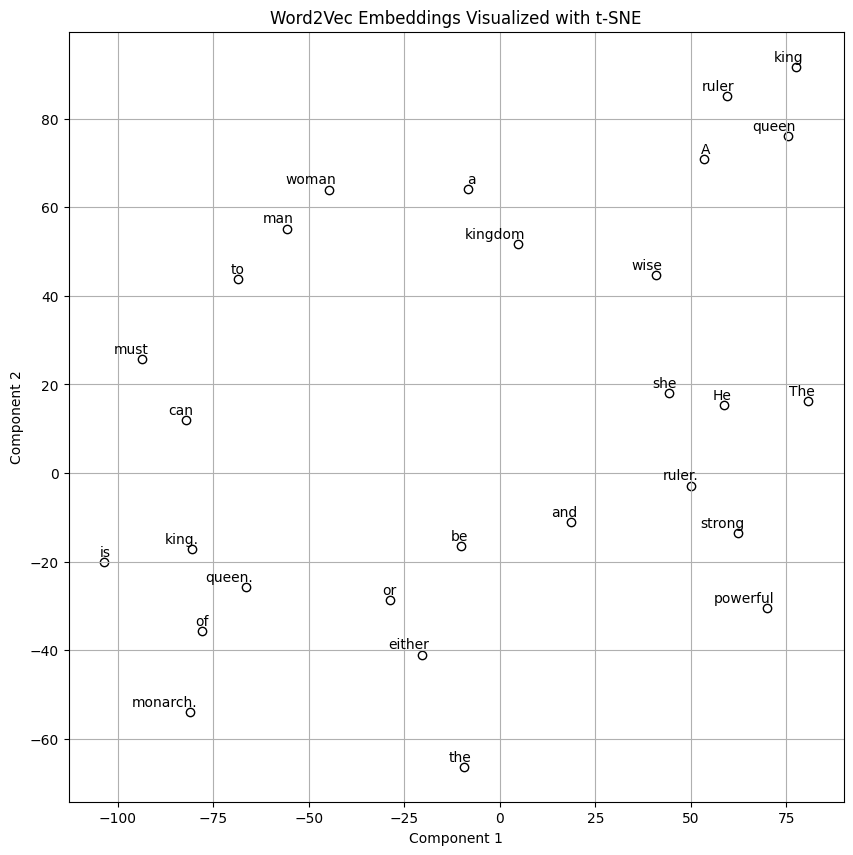

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(W1)
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], edgecolors='k', c='w')

for i, word in enumerate(vocab):
    plt.annotate(word,
                 xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
                 xytext=(5, 2), # Small offset
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.title('Word2Vec Embeddings Visualized with t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

Observation

Skip gram embeddings are much better then CBOW

But CBOW is much faster to train because the whole window is one training point as compared to skip gram where one window becomes multiple training points.